# Thermal evolution of exoplanetary cores

This code solves the thermal evolution of the cores of planets having different mass, iron content, and mantle iron number. The structural profiles (density, temperature, etc.) and initial inner core sizes are obtained from the interior structure model developed by Noack and Lasbleis (2020), along with evolution of the CMB heat flux evolution. The code solves the energy balance equation as in Labrosse (2015), as well as the magnetic evolution obtained by calculating the thermal and buouancy fluxes and calculating the magnetic moment following the relation by Olson and Christensen 2006.

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import pandas as pd
import sympy as sp
import warnings
from scipy.optimize import minimize_scalar
warnings.filterwarnings('ignore')

## Constants

In [2]:
year              = 365.25*3600*24    # 1 year (s)
GC                = 6.67e-11          # Gravitational constant (m3 kg-1 s-2)
Ak                = 2.39              # Radial dependence of conductivity
beta              = 0.2               # Saturation constant for fast rotating polar dynamos
mu_0              = 4*np.pi*1e-7      # Magnetic permeability (Hm-1)
M_Earth           = 5.972e24          # Mass of the Earth (kg)
k_c               = 150               # Core conductivity (estimated)
#g_c              = 5                 # Core gravity (estimated)
magn_moment_Earth = 7.8e22            # Magnetic moment Earth (Am2)

plots_folder = "../Figures/"   # Folder in which to save plots

## Rocky planet class 

Defines physical parameters of a given planet. Parameters are read from yaml files.

In [3]:
class Rocky_Planet():

    def __init__(self):
        self.parameters()

    def read_parameters(self, file): 
        """Read parameters from yaml file"""
        with open(file, 'r') as stream:
            try:
                dict_param = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        for k, v in dict_param.items():
            setattr(self, k, float(v))

## Evolution class

Calculates the thermal evolution of a given planet.

In [4]:
class Evolution():

    def __init__(self, planet):
        self.planet = planet
        
        '''Initialize matrices'''
        self.r_IC = np.zeros_like(self.planet.time_vector)
        self.drIC_dt = np.zeros_like(self.planet.time_vector)
        self.T = np.zeros_like(self.planet.time_vector)
        self.dT_dt = np.zeros_like(self.planet.time_vector)
        self.PC = np.zeros_like(self.planet.time_vector)
        self.PL = np.zeros_like(self.planet.time_vector)
        self.PX = np.zeros_like(self.planet.time_vector)
        self.QC = np.zeros_like(self.planet.time_vector)
        self.QL = np.zeros_like(self.planet.time_vector)
        self.QX = np.zeros_like(self.planet.time_vector)
        self.Q_CMB = np.zeros_like(self.planet.time_vector)
        self.T_CMB = np.zeros_like(self.planet.time_vector)
        self.SC = np.zeros_like(self.planet.time_vector)
        self.TC = np.zeros_like(self.planet.time_vector)
        self.SR = np.zeros_like(self.planet.time_vector)
        self.TR = np.zeros_like(self.planet.time_vector)
        self.Sk = np.zeros_like(self.planet.time_vector)
        self.Tphi = np.zeros_like(self.planet.time_vector)
        self.phi = np.zeros_like(self.planet.time_vector)
        self.qc_ad = np.zeros_like(self.planet.time_vector)
        self.F_th = np.zeros_like(self.planet.time_vector) 
        self.F_X = np.zeros_like(self.planet.time_vector)
        self.Bc = np.zeros_like(self.planet.time_vector)
        self.Bs = np.zeros_like(self.planet.time_vector)
        self.M = np.zeros_like(self.planet.time_vector)
        self.g_c = np.zeros_like(self.planet.time_vector)
        self.M_ratio = np.zeros_like(self.planet.time_vector)
        self.P_IC = np.zeros_like(self.planet.time_vector)
        self.Delta_time = self.planet.time_vector.diff()*year
        
# ------------------------------------------------------------------------------------------------------------------- #
                
        if self.planet.r_IC_0 == 0.0:
            '''If no initial inner core, P and T are same as in yaml parameter file'''
            self.T[0] = self.planet.T0 
            self.P_IC[0] = self.planet.P0

        else:                  
            '''If initial inner core, define T by using the melting temperature by Stixrude'''
            '''Define P by calculating the pressure at the ICB radius'''
            self.P_IC[0] = self.pressure_diff(self.planet.r_IC_0)+self.planet.P0
            P_IC = self.P_IC[0]
            self.T[0] = self.T_liquidus_core(P_IC, S)            
            #self.T[0] = self.T_melt(self.planet.r_IC_0)
            
        '''Initial inner core radius, CMB heat flux and temperature set to 0 for now'''
        '''I do this because the first value in the file of Lena is negative'''
        self.r_IC[0] = self.planet.r_IC_0
        self.Q_CMB[0] = 0
        self.T_CMB[0] = self.T_adiabat(self.planet.r_OC,self.T[0])

# ------------------------------------------------------------------------------------------------------------------- #

        
    '''Run evolution model'''         
    def run(self):
        
        for i,time in enumerate(self.planet.time_vector[1:]):
            
            # during the first crystallizing timestep
            #find dt so that updatenoic returns T=Tmelt
            #run updateic with dt0-dt
            
            '''No initial inner core --> update_noic routine'''
            if self.r_IC[i] == 0.0 and self.T[i] > self.planet.TL0:
                              
                T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX,qc_ad, F_th, F_X, Bc, Bs, M,M_ratio,P_IC =  self.update_noic(self.T[i],self.Delta_time[i+1],self.planet.qcmb[i])
                '''Shift updated value to the next time step'''
                self.T[i+1] = T 
                self.dT_dt[i+1] = dT_dt
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB
                self.QC[i+1] = QC
                self.QL[i+1] = QL
                self.QX[i+1] = QX
                self.qc_ad[i+1] = qc_ad
                self.F_th[i+1] = F_th
                self.F_X[i+1] = F_X
                self.Bc[i+1] = Bc
                self.Bs[i+1] = Bs
                self.M[i+1] = M
                self.M_ratio[i+1] = M_ratio
                self.P_IC[i+1] = P_IC
                
#                 print ("PL",i+1, self.PL[i+1])
#                 print ("drICdt",i+1,self.drIC_dt[i+1]) 
#                 print ("PICB",i+1,self.P_IC[i+1]) 

#                 '''For the first step at which an inner core starts forming, look for the inner core radius'''
#                 if self.T[i+1] < self.planet.TL0:
#                     self.r_IC[i+1] = self.find_r_IC(T)
#                     r_IC_core0 = self.r_IC[i+1]
#                 print (i+1,self.r_IC[i+1])
#                     self.P_IC[i+1] = self.pressure_diff(r_IC_core0)+self.planet.P0
#                     #print (i+1,self.P_IC[i+1])
#                     P_IC_core0 = self.P_IC[i+1]
                    
                if self.T[i+1] < self.planet.TL0:
                    #self.r_IC[i+1] = self.find_r_IC(T)
                    #r_IC_core0 = self.r_IC[i+1]
                    #self.P_IC[i+1] = self.pressure_diff(r_IC_core0)+self.planet.P0
                    #P_IC_core0 = self.P_IC[i+1]
                    
                    T = self.planet.TL0
                    Delta_t_ic = (T-self.T[i])/self.dT_dt[i]
                    dt_rem = self.Delta_time[i+1]-Delta_t_ic
                    
                    #print (dt_rem/self.Delta_time[i+1])
                    #print (self.Q_CMB[i])

                    
                    '''Initial inner core --> update_ic routine'''  
                    T, r_IC, drIC_dt, PC, PL, PX, Q_CMB,T_CMB, QC, QL, QX,qc_ad, F_th, F_X, Bc, Bs, M,M_ratio,P_IC =  self.update_ic(self.r_IC[i], dt_rem,self.planet.qcmb[i],self.P_IC[i],S)
                    self.T[i+1] = T
                    self.r_IC[i+1] = r_IC
                    self.drIC_dt[i+1] = drIC_dt
                    self.PC[i+1] += PC
                    self.PL[i+1] = PL
                    self.PX[i+1] = PX
                    self.Q_CMB[i+1] = Q_CMB
                    self.T_CMB[i+1] = T_CMB   
                    self.QC[i+1] += QC
                    self.QL[i+1] = QL
                    self.QX[i+1] = QX
                    self.qc_ad[i+1] = qc_ad
                    self.F_th[i+1] = F_th
                    self.F_X[i+1] = F_X
                    self.Bc[i+1] = Bc
                    self.Bs[i+1] = Bs
                    self.M[i+1] = M
                    self.M_ratio[i+1] = M_ratio
                    self.P_IC[i+1] = P_IC
                    
                                        
            else: 
               
                '''Initial inner core --> update_ic routine'''  
                T, r_IC, drIC_dt, PC, PL, PX, Q_CMB,T_CMB, QC, QL, QX,qc_ad, F_th, F_X, Bc, Bs, M,M_ratio,P_IC =  self.update_ic(self.r_IC[i], self.Delta_time[i+1],self.planet.qcmb[i],self.P_IC[i],S)
                self.T[i+1] = T
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB   
                self.QC[i+1] = QC
                self.QL[i+1] = QL
                self.QX[i+1] = QX
                self.qc_ad[i+1] = qc_ad
                self.F_th[i+1] = F_th
                self.F_X[i+1] = F_X
                self.Bc[i+1] = Bc
                self.Bs[i+1] = Bs
                self.M[i+1] = M
                self.M_ratio[i+1] = M_ratio
                self.P_IC[i+1] = P_IC
                
#                 print ("PL",i+1, self.PL[i+1])
#                 print ("drICdt",i+1,self.drIC_dt[i+1]) 
#                 print ("PICB",i+1,self.P_IC[i+1])
#                 print ("rIC",i+1,self.r_IC[i+1])

# ------------------------------------------------------------------------------------------------------------------- #
         
        self.t_mf = 0
        '''Magnetic field lifetime routine'''
        for i in range(1,len(self.planet.time_vector)-1):
            if self.M[i-1]==0 and self.M[i]!=0:
                t_start = self.planet.time_vector[i]
            if self.M[i+1]==0 and self.M[i]!=0 and self.M[i-1]!=0:
                t_end = self.planet.time_vector[i]
                self.t_mf = (t_end - t_start)*1e-9
                #print ("The magnetic field lifetime is %.2f billion years."%(self.t_mf)) 

# ------------------------------------------------------------------------------------------------------------------- #
                
        '''Figures'''
        fig, ax1 = plt.subplots()
        ax1.plot(self.planet.time_vector,self.T, color='rebeccapurple')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Temperature at the center/ICB (K)',color='rebeccapurple')
        plt.gca().set_xlim(left=self.planet.time_vector[1]) 
        ax1.tick_params(axis='y', labelcolor='rebeccapurple')
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(self.planet.time_vector,self.r_IC/1e3, color='tomato')
        ax2.set_xlabel('Time (years)')
        ax2.set_ylabel('Inner core radius (km)',color='tomato')
        ax2.tick_params(axis='y', labelcolor='tomato')
        plt.savefig(plots_folder + 'T+r_IC_{}ME_{}XFe_{}FeM_poster.pdf'.format(Mp,XFe,FeM), bbox_inches="tight")
        plt.show()

        plt.plot(self.planet.time_vector[1:],self.QC[1:], label='Secular cooling',color='lightseagreen')
        plt.plot(self.planet.time_vector[1:],self.QL[1:],label='Latent heat',color='sandybrown')
        plt.plot(self.planet.time_vector[1:],self.QX[1:], label='Gravitational heat',color='pink')
        plt.plot(self.planet.time_vector[1:],self.QL[1:]+self.QC[1:]+self.QX[1:], label='Total ($Q_{\mathrm{CMB}}$)',color='navy')
        plt.xlabel('Time (years)')
        plt.ylabel('Contributions to energy balance (W)')
        plt.title('$M=$ %.1f $M_{\oplus}$, $C_{\mathrm{Fe}}=$ %.0f wt %%' %(np.float(Mp),np.float(XFe)))
        plt.gca().set_xlim(left=self.planet.time_vector[1])
        plt.legend()
        plt.savefig(plots_folder + 'Energy_balance_{}ME_{}XFe_{}FeM.pdf'.format(Mp,XFe,FeM), bbox_inches="tight")
        plt.show()
        
        plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1)  
        plt.plot(self.planet.time_vector,self.Q_CMB,color='royalblue')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB heat flow (W)')
        plt.gca().set_xlim(left=self.planet.time_vector[1])  
        plt.subplot(1, 2, 2)         
        plt.plot(self.planet.time_vector,self.T_CMB,color='royalblue')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB temperature (K)')
        plt.suptitle('$M=$ %.1f $M_{\oplus}$, $C_{\mathrm{Fe}}=$ %.0f wt %%' %(np.float(Mp),np.float(XFe)))
        plt.gca().set_xlim(left=self.planet.time_vector[1]) 
        plt.subplots_adjust(wspace=0.4)
        plt.savefig(plots_folder + 'QCMB_TCMB_{}ME_{}XFe_{}FeM.pdf'.format(Mp,XFe,FeM), bbox_inches="tight")
        plt.show()
        
        plt.plot(self.planet.time_vector,self.F_th, label='Temperature',color='tomato')
        plt.plot(self.planet.time_vector,self.F_X, label='Composition',color='mediumseagreen')
        plt.xlabel('Time (years)')
        plt.ylabel('Buoyancy fluxes ($m^{2}s^{-3}$)')
        plt.title('$M=$ %.1f $M_{\oplus}$, $C_{\mathrm{Fe}}=$ %.0f wt %%' %(np.float(Mp),np.float(XFe)))
        plt.gca().set_xlim(left=self.planet.time_vector[1]) 
        plt.legend()
        plt.savefig(plots_folder + 'Fluxes_{}ME_{}XFe_{}FeM.pdf'.format(Mp,XFe,FeM), bbox_inches="tight")
        plt.show()
        
        plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1)  
        plt.plot(self.planet.time_vector,self.Bc * 1e3,label='CMB',color='tomato')
        plt.plot(self.planet.time_vector,self.Bs * 1e3,label='Surface',color='mediumseagreen')
        plt.xlabel('Time (years)')
        plt.ylabel('rms dipole field (mT)')
        plt.semilogy()
        plt.gca().set_xlim(left=self.planet.time_vector[1]) 
        plt.legend()
        ax1 = plt.subplot(1, 2, 2) 
        ax1.plot(self.planet.time_vector,self.M,color='grey')
        ax1.set_ylabel('Magnetic moment ($A m^{2}$)')
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Magnetic moment present Earth ($A m^{2}$)')  
        ax2.plot(self.planet.time_vector,self.M_ratio,color='grey')
        ax2.tick_params(axis='y')
        plt.xlabel('Time (years)')
        plt.suptitle('$M=$ %.1f $M_{\oplus}$, $C_{\mathrm{Fe}}=$ %.0f wt %%' %(np.float(Mp),np.float(XFe)))
        plt.gca().set_xlim(left=self.planet.time_vector[1]) 
        plt.subplots_adjust(wspace=0.4)
        plt.savefig(plots_folder + 'MField_{}ME_{}XFe_{}FeM.pdf'.format(Mp,XFe,FeM), bbox_inches="tight")
        plt.show()

# ------------------------------------------------------------------------------------------------------------------- #

    '''Routine for no initial inner core'''
    def update_noic(self,T,Delta_time,qcmb):
        
        fC = self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma)
        
        ''' Secular cooling power '''
        PC = (-4*np.pi/3*self.planet.rho_0*self.planet.CP*self.planet.L_rho**3*fC)
                
        ''' Latent heat power '''
        PL = 0.

        ''' Gravitational heat power '''
        PX = 0.      
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb

        '''Temperature increase at center'''
        dT_dt = Q_CMB/PC 
        
        ''' New central temperature '''
        T = T + dT_dt * Delta_time 
        
        ''' Inner core growth '''
        drIC_dt = 0.
        
        ''' Inner core size'''
        r_IC = 0.
        
        P_IC = self.planet.P0
                
        '''Temperature at CMB'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        '''Secular cooling power'''
        QC = PC * dT_dt
        
        ''' Latent heat power '''
        QL = 0.

        ''' Gravitational heat power '''
        QX = 0. 
        
#         '''Entropy contribution of secular cooling'''
#         SC = self._SC(r_IC,drIC_dt,P_IC,S)
        
#         TC = self._TC(r_IC,P_IC,S)
        
#         '''Entropy contribution of radiocativity (assumed to be 0)'''
#         SR = 0.
        
#         TR = self._TR(r_IC,P_IC,S)
        
#         '''Entropy contribution of conduction'''
#         Sk = self._Sk(r_IC)
        
#         '''Dissipation temperature'''
#         Tphi = self._Tphi(T,r_IC)
        
#         '''Efficiency factor'''
#         phi = self._eff_noic(Tphi,TC,T_CMB,QC,TR,0,Sk)
        
        '''Isentropic heat flux'''
        qc_ad = self._qc_ad(k_c,T_CMB,r_IC)

        '''Gravity at CMB'''
        g_c = self._gravity_CMB(XFe,FeM,Mp)
        
        '''Thermal buoyancy'''
        F_th = self._F_th(g_c,qcmb,qc_ad)
        
        '''Compositional buoyancy'''
        F_X = 0 #self._F_X(g_c,r_IC,drIC_dt)
        
        R_planet = self._R_planet(XFe,Mp)
        rho_OC = self._density(self.planet.r_OC)
        
        '''rms dipole field @ CMB'''
        Bc = self._Bc(rho_OC,F_th,F_X,r_IC)
        
        '''rms dipole field @ surface'''
        Bs = self._Bs (Bc,R_planet)
        
        '''Magnetic moment (Am2)'''
        M = self._magn_moment(rho_OC,F_th,F_X,r_IC)
        
        M_ratio = M/magn_moment_Earth
                
        return T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX, qc_ad, F_th, F_X, Bc, Bs, M, M_ratio, P_IC
    
    '''Routine for initial inner core'''    
    def update_ic(self, r_IC, Delta_time,qcmb,P_IC,S):
        
        '''Secular cooling power'''
        PC = self._PC(r_IC,P_IC,S)
        
        '''Latent heat power'''
        PL = self._PL(r_IC,P_IC,S)
        
        '''Gravitational heat power'''
        PX = self._PX(r_IC)
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb
                
        '''Inner core growth rate'''
        drIC_dt = Q_CMB/(PC + PL + PX)
                        
        '''Inner core radius'''
        r_IC = r_IC + drIC_dt * Delta_time
                                                        
        P_IC = self.pressure_diff(r_IC) + self.planet.P0
        
        '''Temperature at the ICB'''        
        #T = self.T_melt(r_IC)
        T = self.T_liquidus_core(P_IC, S)
            
        '''CMB temperature'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        '''Secular cooling power'''
        QC = PC*drIC_dt
        
        '''Latent heat power'''
        QL = PL*drIC_dt
        
        '''Gravitational heat power'''
        QX = PX*drIC_dt
        
#         '''Entropy contribution of secular cooling'''
#         SC = self._SC(r_IC,drIC_dt,P_IC,S)
        
#         TC = self._TC(r_IC,P_IC,S)
        
#         '''Entropy contribution of radiocativity (assumed to be 0)'''
#         SR = 0.
        
#         TR = self._TR(r_IC,P_IC,S)

#         '''Entropy contribution of conduction'''
#         Sk = self._Sk(r_IC)
        
#         '''Dissipation temperature'''
#         Tphi = self._Tphi(T,r_IC)
        
#         '''Efficiency factor'''
#         phi = self._eff_ic(Tphi,TC,T_CMB,QC,TR,0,Sk,QX,T,QC,QL) 
        
        '''Isentropic heat flux'''
        qc_ad = self._qc_ad(k_c,T_CMB,r_IC)
        
        '''Gravity at CMB'''
        g_c = self._gravity_CMB(XFe,FeM,Mp)
                
        '''Thermal buoyancy'''
        F_th = self._F_th(g_c,qcmb,qc_ad)
        
        '''Compositional buoyancy'''
        F_X = self._F_X(g_c,r_IC,drIC_dt)
                
        R_planet = self._R_planet(XFe,Mp)
        rho_OC = self._density(self.planet.r_OC)
                
        '''rms dipole field @ CMB'''
        Bc = self._Bc(rho_OC,F_th,F_X,r_IC)
        
        '''rms dipole field @ surface'''
        Bs = self._Bs (Bc,R_planet)
                
        '''Magnetic moment (Am2)'''
        M = self._magn_moment(rho_OC,F_th,F_X,r_IC)
                        
        M_ratio = M/magn_moment_Earth
                                                
        return T,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX,qc_ad, F_th, F_X, Bc, Bs, M, M_ratio, P_IC

# ------------------------------------------------------------------------------------------------------------------- #
    
    '''Functions for calculations'''    
#     def dTL_dr_IC(self, r,S):
#         '''Labrosse'''
#         S=0
#         result = -self.planet.K_c * 2.*self.planet.dTL_dP * r / self.planet.L_rho**2. \
#             + 3. * self.planet.dTL_dchi * self.planet.chi0 * r**2. / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))
#         return result
    
    def dTL_dr_IC(self,r0,S):
        
        ''' Melting temperature jump at ICB '''
        '''Stixrude'''
        K0 = (2./3. * np.pi * self.planet.L_rho**2 * self.planet.rho_0**2 *GC)/1e9
#         B = 6500./(1-np.log(1-S* 1e-2))
#         der = (1.03 * self.planet.L_rho**2 * r - 1.648 * r**3) \
#         /(self.planet.L_rho**4 * (r**2 / self.planet.L_rho**2 - (4 * r**4)/(5 * self.planet.L_rho**4))**(0.485))
#         result = (-A/340.)**(0.515) * B * der
        
        r = sp.symbols('r')
        
        P = self.planet.P0 - K0 * (r**2/self.planet.L_rho**2 - (4*r**4)/(5*self.planet.L_rho**4))
        
        S_t = S * self.M_OC(self.planet.r_IC) /(4./3. * np.pi * self.planet.rho_0 * self.planet.L_rho**3 * (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0)))
        
        function = 6500 * (P/340)**(0.515) * 1./(1-sp.log(1-S_t))
        
        derivative = sp.diff(function,r).subs(r,r0).evalf()
                
        return derivative
    
    def M_OC(self,r):
        '''Equation M_OC(t) in our paper'''
        return 4./3. * np.pi * self.planet.rho_0 * self.planet.L_rho**3 * (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0))
        
        
    def fC(self, r, delta): 
        '''fC (Eq. A1 Labrosse 2015)'''
        return r**3. * (1 - 3. / 5. * (delta + 1) * r**2.- 3. / 14. * (delta + 1) \
            * (2 * self.planet.A_rho - delta) * r**4.)

    def fX(self, x, r):
        '''fX (Eq. A15 Labrosse 2015)'''
        return (x)**3. * (-r**2. / 3. / self.planet.L_rho**2. + 1./5. * (1.+(r**2)/self.planet.L_rho**2.) \
                *(x)**2.-13./70. * (x)**4.) 

    def rho(self, r):
        ''' Density (Eq. 5 Labrosse 2015)'''
        return self.planet.rho_0 * (1. - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)

    def T_melt(self, r):
        ''' Melting temperature (Eq. 14 Labrosse 2015)'''
        return self.planet.TL0 - self.planet.K_c * self.planet.dTL_dP * r**2. / self.planet.L_rho**2. + self.planet.dTL_dchi * self.planet.chi0 * r**3. \
                / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))
    
    def T_liquidus_core(self,P, S):
        '''Melting temperature (Stixrude 2014)'''
        """ T_{\rm melt} = 6500 * (p/340)^{0.515} / (1 - ln(1-X_{\rm S}) ) """
        return 6500*(P/340)**(0.515) * (1./(1-np.log(1-S * 1e-2)))
        #return 6500.*(P/340)**0.515/(1-np.log(1-S))
     
    def _PL(self, r,P,S):
        '''Latent heat power'''
        return 4. * np.pi * r**2. * self.T_liquidus_core(P, S) * self.rho(r) * self.planet.DeltaS
        #return 4. * np.pi * r**2. * self.T_melt(r) * self.rho(r) * self.planet.DeltaS

    def _PC(self, r,P,S):
        '''Secular cooling power (Eq. A8 Labrosse 2015)'''
        return -4. * np.pi / 3. * self.planet.rho_0 * self.planet.CP * self.planet.L_rho**3. *\
                (1 - r**2. / self.planet.L_rho**2 - self.planet.A_rho* r**4. / self.planet.L_rho**4.)**(-self.planet.gamma) \
                * (self.dTL_dr_IC(r,S) + 2. * self.planet.gamma \
                * self.T_liquidus_core(P, S) * r / self.planet.L_rho**2. *(1 + 2. * self.planet.A_rho * r**2. / self.planet.L_rho**2.) \
                /(1 - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)) \
                * (self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma)-self.fC(r / self.planet.L_rho, self.planet.gamma))

    def _PX(self, r):
        ''' Gravitational heat power (Eq. A14 Labrosse 2015)'''
        return 8 * np.pi**2 * self.planet.chi0 * GC * self.planet.rho_0**2 * self.planet.beta * r**2. \
        * self.planet.L_rho**2. / self.fC(self.planet.r_OC / self.planet.L_rho, 0) \
        * (self.fX(self.planet.r_OC / self.planet.L_rho, r) - self.fX(r / self.planet.L_rho, r))

    def pressure_diff(self,r):  
        '''Pressure difference (GPa)'''
        K0 = self.planet.L_rho**2/3.*2.*np.pi*GC*self.planet.rho_0**2 /1e9 #in GPa
        K0 = (2./3. * np.pi * self.planet.L_rho**2 * self.planet.rho_0**2 *GC)/1e9
        factor = (r**2)/(self.planet.L_rho**2)-(4.*r**4)/(5.*self.planet.L_rho**4)
        return -K0*factor
    
    def T_adiabat(self,r,T):
        '''Adiabatic temperature''' 
        return T*(1-r**2/self.planet.L_rho**2-self.planet.A_rho*r**4/self.planet.L_rho**4)**self.planet.gamma
    
    '''Find inner core radius when it first starts forming'''
    def find_r_IC(self, T0):       
        def Delta_T(radius):
            P = self.pressure_diff((radius))+self.planet.P0
            Ta = self.T_adiabat(radius,T0)
            TL = self.T_liquidus_core(P, S)
            return (Ta - TL)**2
        res = minimize_scalar(Delta_T, bounds=(0., 6e6), method='bounded') #, constraints={'type':'ineq', 'fun': lambda x: x})  #result has to be >0
        r_IC = res.x
        if r_IC < 1: r_IC = np.array(0.)
        return r_IC.tolist()
    
    def _SC(self,r,drIC_dt,P,S):
        '''Entropy contribution of secular cooling (Labrosse 2015, Eq. A11)'''
        return (-4 * np.pi * self.planet.rho_0 * self.planet.CP * self.planet.L_rho**3)/(3*self.T_liquidus_core(P, S)) * (self.dTL_dr_IC(r,S) \
                + 2 * self.planet.gamma * self.T_liquidus_core(P, S)*r/self.planet.L_rho**2 *(1 + 2 * self.planet.A_rho * r**2 / self.planet.L_rho**2) \
                /(1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)) * (self.fC(self.planet.r_OC/self.planet.L_rho,0) \
                - self.fC(r/self.planet.L_rho,0)) * drIC_dt
    
    def _TC(self,r,P,S):
        '''Temperature at which secular cooling contributes to the entropy balance (Labrosse 2015, Eq. A12)'''
        return self.T_liquidus_core(P, S) * (1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)**(-self.planet.gamma) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,self.planet.gamma) - self.fC(r/self.planet.L_rho,self.planet.gamma)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0))
    
    def _SR(self,h,r,P,S):
        '''Entropy contribution from radiogenic heating (Labrosse 2015, Eq. A18)'''
        return 4 * np.pi * self.planet.rho_0 * self.planet.L_rho**3 * h / (3 * self.T_liquidus_core(P, S)) * (1 - r**2/self.planet.L_rho**2 - self.planet.A_rho \
                * r**4/self.planet.L_rho**4)**(-self.planet.gamma) * (self.fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma) - self.fC(r/self.planet.L_rho,-self.planet.gamma))
    
    def _TR(self,r,P,S):
        '''Temperature at which radiogenic dissipation occurs (Labrosse 2015, Eq. A19)'''
        return self.T_liquidus_core(P, S) * (1-r**2/self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)**(self.planet.gamma) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,0) - self.fC(r/self.planet.L_rho,0)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma) - self.fC(r/self.planet.L_rho,-self.planet.gamma))
        
    def _Sk(self,r):
        '''Contribution of conduction to the entropy balance (Labrosse 2015, Eq. A20)'''
        return 16 * np.pi * self.planet.gamma**2 * self.planet.k_c * self.planet.L_rho * (self.fk(self.planet.r_OC/self.planet.L_rho)-self.fk(r/self.planet.L_rho))
    
    def fk(self,x):
        '''Labrosse 2015, Eq. A23'''
        return x**5 / 5. * (1 + 5./7. * (2 - Ak + 4 * self.planet.A_rho)*x**2 + 5./9. *(3 + 10 * self.planet.A_rho + 4 * self.planet.A_rho**2 \
                - 2 * Ak *(1 + 2 * self.planet.A_rho))* x**4)
    
    def _Tphi(self,T,r):
        '''Effective dissipation temperature (Labrosse 2015, Eq. A24)'''
        '''T is T_melt(r_IC) when there is an inner core, T0 when there is no inner core'''
        return T / ((1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4/self.planet.L_rho**4)**(self.planet.gamma)) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma)-self.fC(r/self.planet.L_rho,-self.planet.gamma))
    
    def _eff_noic(self,Tphi,TC,T_CMB,QC,TR,QR,Sk):
        '''Efficiency factor before inner core crystallization (Labrosse 2015, Eq. 40)'''
        return Tphi * (TC-T_CMB) / (T_CMB * TC) * QC + Tphi * (TR - T_CMB)/(T_CMB * TR) * QR - Tphi * Sk
    
    def _eff_ic(self,Tphi,TC,T_CMB,QC,TR,QR,Sk, QX,T_ICB,QICB,QL):
        '''Efficiency factor when there is an inner core (Labrosse 2015, Eq. 35)'''
        return Tphi * (TC-T_CMB) / (T_CMB * TC) * QC + Tphi * (TR - T_CMB)/(T_CMB * TR) * QR - Tphi * Sk \
                + Tphi / T_CMB * QX + (Tphi * (T_ICB-T_CMB)/(T_CMB * T_ICB)) * (QICB + QL)
    
    def _Bc(self,rho_OC,F_th,F_X,r_IC):
        
        if (F_th+F_X)<0:
            Bc = 0
        else:
            '''rms dipole field intensity at the CMB (Olson + Christensen 2006, unit:T)'''
            Bc = beta * np.sqrt(rho_OC * mu_0) * ((F_th+F_X)*self.planet.r_OC)**(1./3.)
        return Bc
    
    def _Bs (self,Bc,r_planet):
        '''rms dipole field intensity at the planetary surface, unit:T'''
        return Bc * (self.planet.r_OC/r_planet)**3 
    
        '''Magnetic moment, unit:Am2 (Olson & Christensen 2006)'''
    def _magn_moment(self,rho_OC,F_th,F_X,r_IC):
        if (F_th + F_X) < 0:
            M = 0
        else:
            M = 4 * np.pi * self.planet.r_OC**3 * beta * np.sqrt(rho_OC/mu_0) * ((F_th + F_X)*(self.planet.r_OC-r_IC))**(1./3.)
        return M
    
    def _buoyancy_flux(self,F_th,F_X):
        '''Buoyancy flux (from Driscoll and Bercovici, eq. 35)'''
        return F_th + F_X
    
    def _F_th(self,g_c,q_cmb,qc_ad):
        '''Thermal buoyancy'''
        return self.planet.alpha_c * g_c / self.planet.rho_0 / self.planet.CP * (q_cmb - qc_ad)
    
    def _qc_ad(self,k_c,T_cmb,r_IC):
        '''Isentropic heat flux at the CMB, unit: W m-2'''
        return k_c * T_cmb * self.planet.r_OC / (6340000)**2
    
    def _F_X(self,g_c,r,drIC_dt):
        '''Compositional buoyancy'''
        return g_c * r / self.planet.r_OC * self.planet.Deltarho_ICB /self.planet.rho_0 * (r/self.planet.r_OC)**2 * drIC_dt
    
    def _density(self,r):
        '''Planetary density'''
        return self.planet.rho_0 * (1-r**2/self.planet.L_rho**2 - self.planet.A_rho * r**4/self.planet.L_rho**4)
    
    def _R_planet(self, XFe,Mp):
        '''Planetary radius (Noack + Lasbleis paper), unit: m'''
        return (7030 - 1840 * XFe*1e-2)*(Mp)**(0.282) * 1000
    
    def _gravity_CMB(self,XFe,FeM,Mp):
        '''Gravity @ CMB (Noack & Lasbleis)'''
        X_CMF = (XFe*1e-2 - FeM*1e-2)/(1-FeM*1e-2)
        return GC*X_CMF*Mp*M_Earth/(self.planet.r_OC)**2

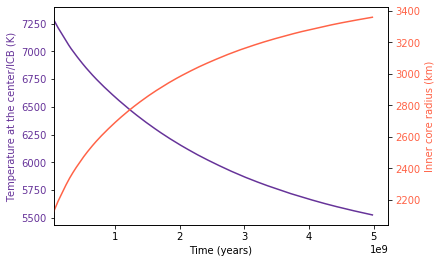

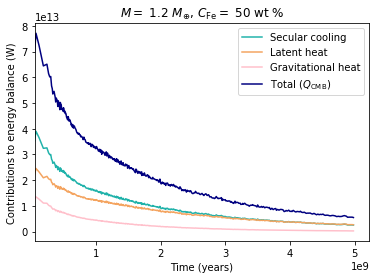

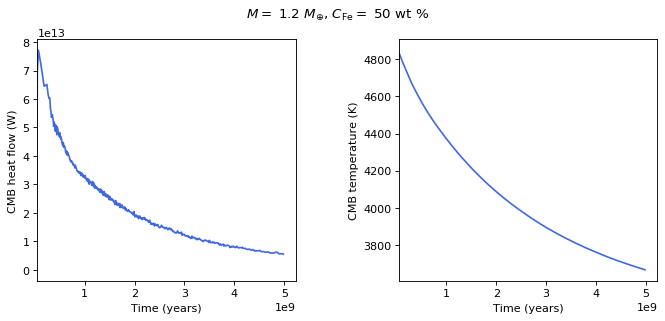

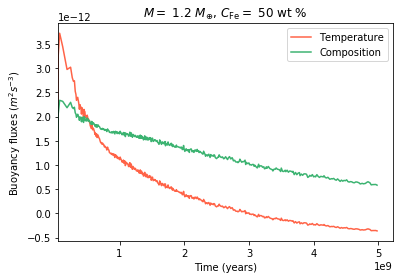

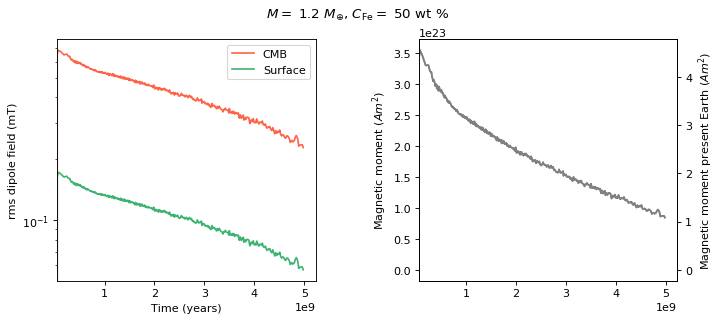

In [5]:
'''Planetary parameters'''
Mp = 1.2
XFe = 50   # 50: inner core. 30: no inner core
FeM = 0.00 # 0.00
S = 0.0   # percentage of light elements in the core

class Exo(Rocky_Planet):
    
    def __init__(self,Mp,XFe,FeM):
        self.parameters(Mp,XFe,FeM)
    
    def parameters(self,Mp,XFe,FeM):
        '''Load parameter files'''
        os.chdir("/Users/irenebonati/Desktop/core/With_DTcmb")
        self.read_parameters("M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM))
        #self.read_parameters("Earth.yaml".format(Mp, XFe, FeM))
        qcmb_ev = pd.read_csv("qc_T_M{:02d}_Fe{:02d}_FeM{:02d}.txt".format(int(10*Mp),int(XFe)+5, int(FeM)), sep=" ", skiprows=1, header=None)
        #qcmb_ev = pd.read_csv("qc_T_M{:02d}_Fe{:02d}_FeM{:02d}.txt".format(int(10*Mp),int(XFe), int(FeM)), sep=" ", skiprows=1, header=None)
        qcmb_ev.columns = ["time", "qcmb", "Tcmb"]
        self.time_vector = qcmb_ev["time"]
        self.qcmb = qcmb_ev["qcmb"]
                
if __name__ == '__main__': 
       
    Evolution(Exo(Mp,XFe,FeM)).run()

## Automatization

For all yaml files, run all calculations and save the results in a big array with the magnetic field lifetime. M needs to have the column size of the planetary masses (M between 0.8 and 2 $M_{Earth}$) and the row number of the amount of iron (20-80). FeM can be set to zero for now.

In [6]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe = [20 , 30 , 40 , 50 , 60 , 70]
FeM = 0
S = 0.0

M, F = np.meshgrid(Masses, Fe)
MF_lifetime = np.zeros_like(M)
r_IC_end = np.zeros_like(M)
Q_CMB_end = np.zeros_like(M)

for i, mass in enumerate(Masses):
    for j,iron in enumerate(Fe):
        Mp = mass
        XFe = iron
        evo = Evolution(Exo(Mp,XFe,FeM))
        evo.run()
        r_IC_end[j,i] = evo.r_IC[-1]/1e3      # Final IC radius (m)
        MF_lifetime[j,i] = evo.t_mf           # Longest MF lifetime (Gyr)
        Q_CMB_end[j,i] = evo.Q_CMB[-1]        # CMB heat flow (W)       

TypeError: Invalid NaN comparison

# Plots

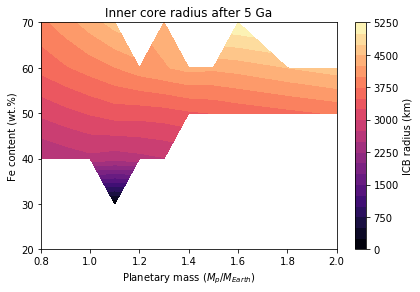

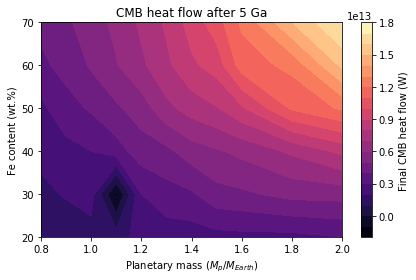

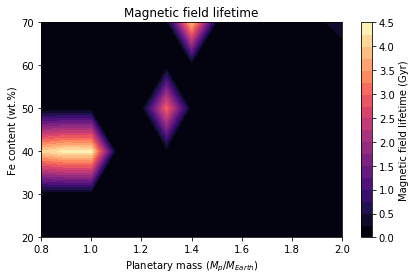

In [12]:
ax = plt.figure()
plt.contourf(M, F, r_IC_end, 20, cmap = plt.cm.magma)
plt.xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
plt.ylabel("Fe content (wt.%)")
cb = plt.colorbar()
cb.set_label("ICB radius (km)")
plt.tight_layout()
plt.title('Inner core radius after 5 Ga')
plt.savefig("r_ICB_final.pdf")
plt.show()

ax = plt.figure()
plt.contourf(M, F, Q_CMB_end, 20, cmap = plt.cm.magma)
plt.xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
plt.ylabel("Fe content (wt.%)")
cb = plt.colorbar()
cb.set_label("Final CMB heat flow (W)")
plt.title("CMB heat flow after 5 Ga")
plt.tight_layout()
plt.savefig("QCMB_final.pdf")
plt.show()

ax = plt.figure()
plt.contourf(M, F, MF_lifetime, 20, cmap = plt.cm.magma)
plt.xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
plt.ylabel("Fe content (wt.%)")
cb = plt.colorbar()
cb.set_label("Magnetic field lifetime (Gyr)")
plt.title("Magnetic field lifetime")
plt.tight_layout()
plt.savefig("MF_lifetime.pdf")
plt.show()

## Derivative of melting temperature

In [13]:
P0, K0, L, S, r = sp.symbols('P0 K0 L S r')

P = P0 - K0 * (r**2/L**2 - (4*r**4)/(5*L**4))

function = 6500 * (P/340)**(0.515) * 1./(1-sp.log(1-S))

der = sp.diff(function,r)

test = sp.diff(r**2)

print ("dTL_drIC =", der)
print ("test =",test)

dTL_drIC = -9.84558823529412*K0*(-K0*(r**2/L**2 - 4*r**4/(5*L**4))/340 + P0/340)**(-0.485)*(2*r/L**2 - 16*r**3/(5*L**4))/(1 - log(1 - S))
test = 2*r


In [ ]:
K0 = (2./3. * np.pi * self.planet.L_rho**2 * self.planet.rho_0**2 *GC)/1e9
        
r = sp.symbols('r')
        
P = self.planet.P0 - K0 * (r**2/self.planet.L_rho**2 - (4*r**4)/(5*self.planet.L_rho**4))
        
S_t = S * self.M_OC(self.planet.r_IC) /(4./3. * np.pi * self.planet.rho_0 * self.planet.L_rho**3 * (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0)))
        
function = 6500 * (P/340)**(0.515) * 1./(1-sp.log(1-S_t))
        
derivative = sp.diff(function,r)